# Annotating Cell Types

This workbook can be run after the standard workflow.
It is demonstrating how to use the  annotation function to annotate the dataset that was runned through the standard worflow.

In this notebook, we will show how to use in-besca annotation to assign cell type to clusters.
We focus on immune celltype and demonstrate signature-scoring functions.


An alternative in the case a an annotated training dataset already exists is to use the auto-annot module. Please refer to the corresponding tutorial.

In [1]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
import logging
import seaborn as sns
sc.logging.print_header()
import IPython

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

scanpy==1.6.1 anndata==0.7.5 umap==0.4.4 numpy==1.18.5 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0


In [2]:
#define standardized filepaths based on above input
root_path = os.getcwd()
bescapath_full = os.path.dirname(bc.__file__)
bescapath = os.path.split(bescapath_full)[0]

analysis_name = 'standard_workflow_besca2.0'

# Choose the clustering to base the annotation on.
# leiden, CLR (CITE-seq), DSB (CITE-seq)
clusters='leiden' 

# Which UMAP basis to use for visualization
# umap or protein_umap
umap_basis='umap'

# If citeseq data, select the normalization that was used:
citeseq=False
# CLR or DSB
adt_norm='' 


The chunk of code below is usefull if this is the initial installation of besca and that you are running this notebook as a test. It will download if needed the test datasets and export the labelling. 
This export is usually done at the end of the standard workflow. Exported files  are necessary for the annotations.

In [3]:
use_example_dataset = False
if use_example_dataset:
    analysis_name='pbmc3k_processed'
    results_folder = os.path.split(os.getcwd())[0] + '/besca/datasets/data/'
    clusters='leiden'
    # This line will either download, or load the datasets
    adata = bc.datasets.pbmc3k_processed()
    # This line exports the annotation for the annotation.
    adata = bc.st.additional_labeling(adata, labeling_to_use= clusters, labeling_name = clusters, 
                                      labeling_description = 'Exporting a postori the labels for annotation',
                                      labeling_author = 'Testing', 
                                      results_folder= results_folder)
else:
    if clusters == 'leiden':
        results_folder = os.path.join(root_path, 'analyzed')
        if citeseq:
            results_folder = os.path.join(results_folder, analysis_name, 'citeseq' + adt_norm, 'citeseq_merged') ## TODO, added
            adata = sc.read_h5ad(os.path.join(results_folder ,analysis_name + '.h5ad') )
        else:
            results_folder = os.path.join(results_folder, analysis_name)
            adata = sc.read_h5ad(os.path.join(results_folder, analysis_name + '.h5ad') )
        
    else:
        results_folder = os.path.join(root_path, 'analyzed', analysis_name, 'citeseq'+clusters, 'citeseq')
        adata = sc.read_h5ad(os.path.join(results_folder + '_merged' ,analysis_name + '.h5ad') )
        clusters='protein_leiden'

In [4]:
results_file = os.path.join(results_folder, analysis_name + '.annotated.updated.h5ad')
figdir=os.path.join(root_path, 'analyzed', analysis_name+'/figures/')
sc.settings.figdir = figdir
if not os.path.exists(figdir):
    os.makedirs(figdir)

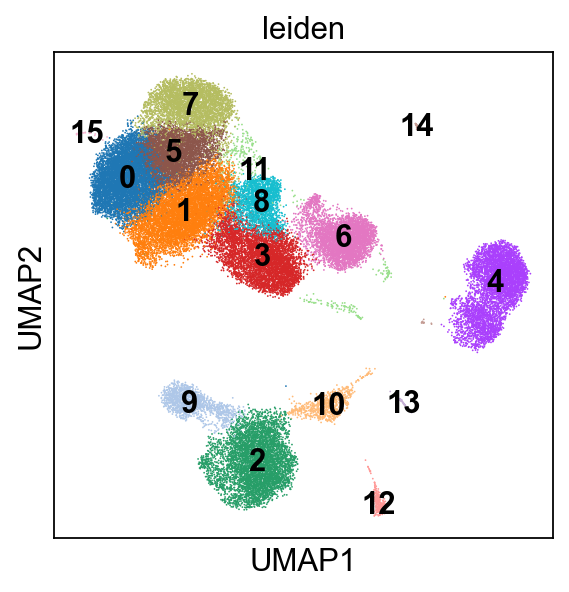

In [5]:
sc.pl.umap(adata, color= [clusters], legend_loc='on data')

In [6]:
if citeseq:
    # Expression pattern of the antibodies
    # Can be usefull to refine the annotations, if the clusters are RNA-based
    ab_names = adata.var[adata.var.feature_type=='Antibody Capture']
    sc.pl.embedding(adata, basis = 'umap', color=ab_names.index.tolist(), color_map = 'viridis')

### Explore top marker genes per cluster 

In [7]:
DEgenes=bc.tl.dge.get_de(adata,clusters,demethod='wilcoxon',topnr=5000, logfc=1,padj=0.05)


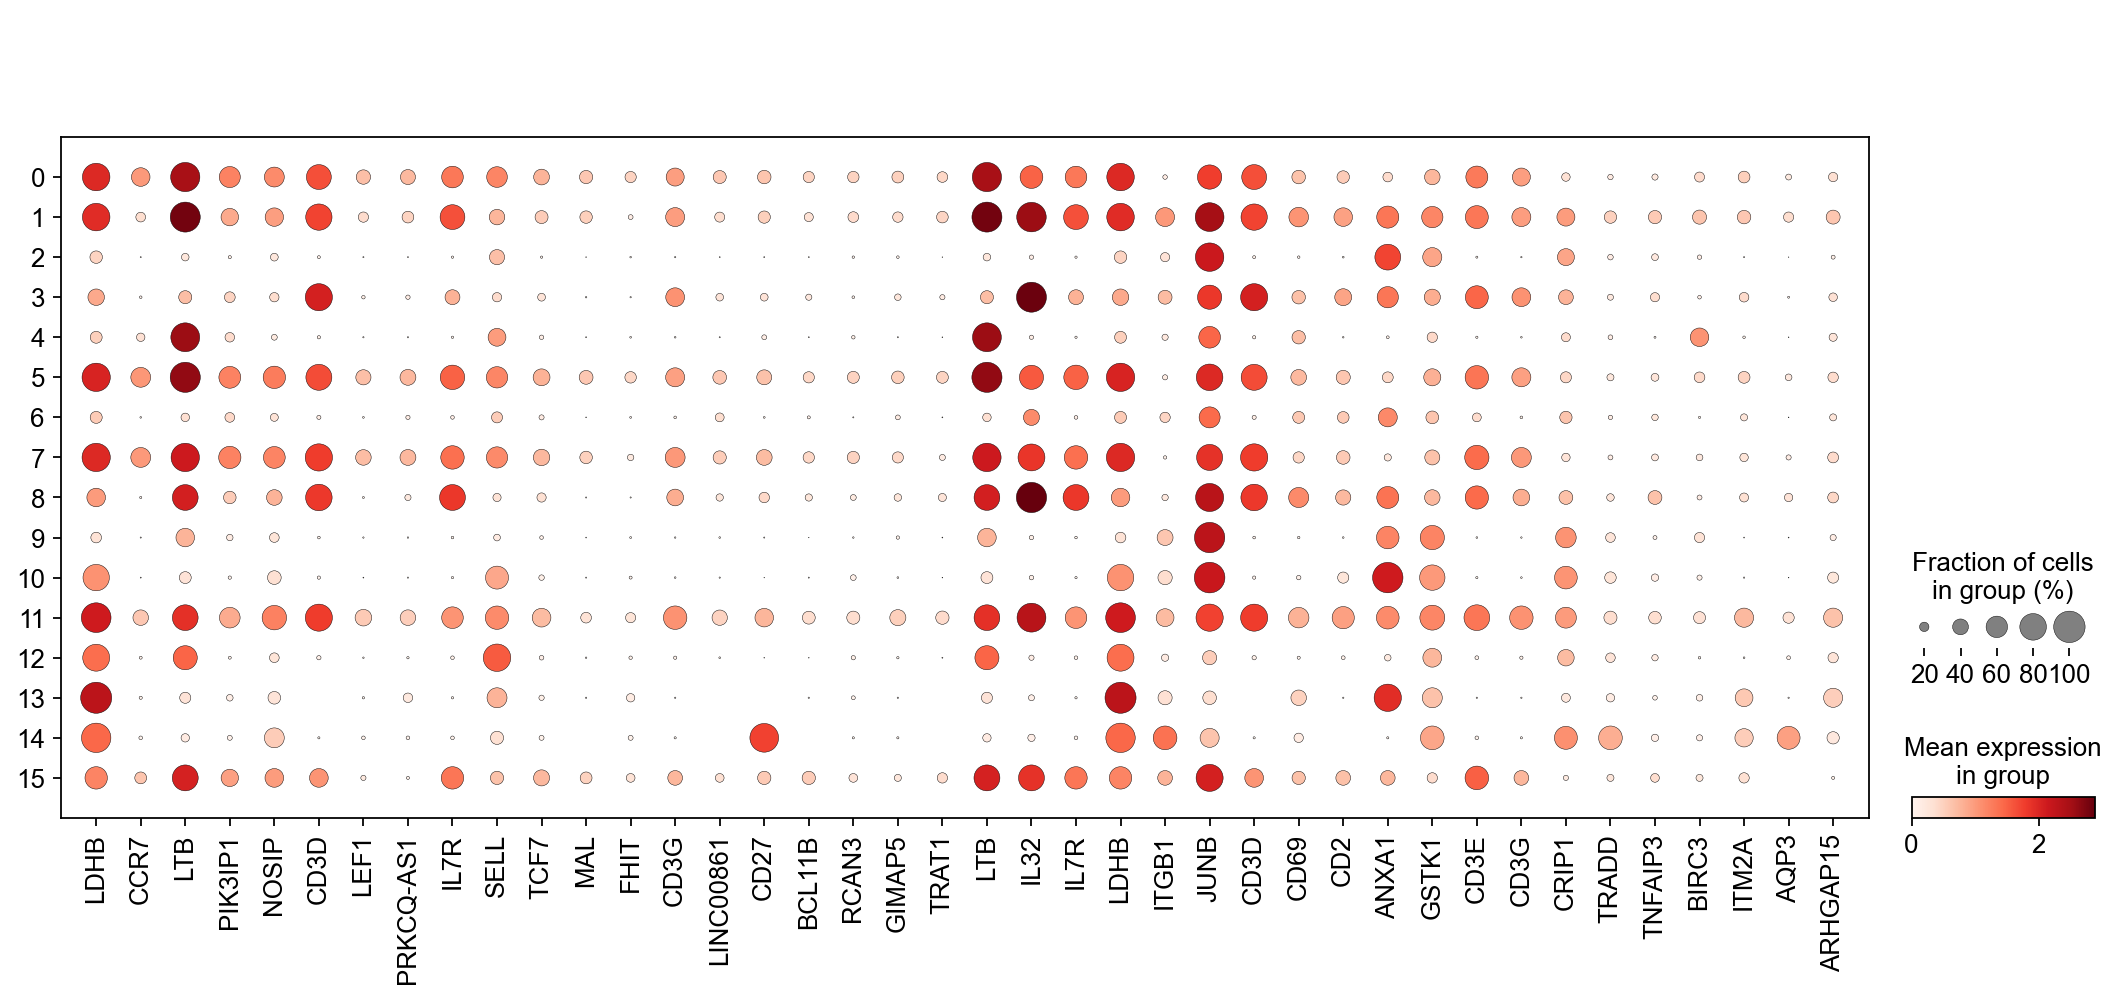

In [8]:
### Select only top genes (in order of p-val) for 2 clusters and plot expression per cluster
tops=list(DEgenes['0']['Name'][0:20])+list(DEgenes['1']['Name'][0:20])
sc.pl.dotplot(adata, var_names=tops,groupby=clusters)

### Explore distribution of various cell populations

In [9]:
# One can load besca-provided signatures using the function below
signature_dict = bc.datasets.load_immune_signatures(refined=False)

signature_dict

{'lymphocyte': ['PTPRC'],
 'myeloid': ['S100A8', 'S100A9', 'CST3'],
 'Bcell': ['CD19', 'CD79A', 'MS4A1'],
 'Tcells': ['CD3E', 'CD3G', 'CD3D'],
 'CD4': ['CD4'],
 'CD8': ['CD8A', 'CD8B'],
 'NKcell': ['NKG7', 'GNLY', 'NCAM1'],
 'monocyte': ['CST3', 'CSF1R', 'ITGAM', 'CD14', 'FCGR3A', 'FCGR3B'],
 'macrophage': ['CD14',
  'IL1B',
  'LYZ',
  'CD163',
  'ITGAX',
  'CD68',
  'CSF1R',
  'FCGR3A']}

Additionaly it is possible to read an compute scanpy score using this function below.

If the gmt file is composed of combined signature (UP and DN), a common score will be computed: 
$$Total\_SCORE= Score_{UP} - Score_{DN}$$

In [10]:
gmt_file= bescapath + '/besca/datasets/genesets/Immune.gmt'
bc.tl.sig.combined_signature_score(adata, gmt_file,
                             UP_suffix='_UP', DN_suffix='_DN', method='scanpy',
                             overwrite=False, verbose=False,
                             use_raw=True, conversion=None)
scores = [x for x in adata.obs.columns if 'scanpy' in x]

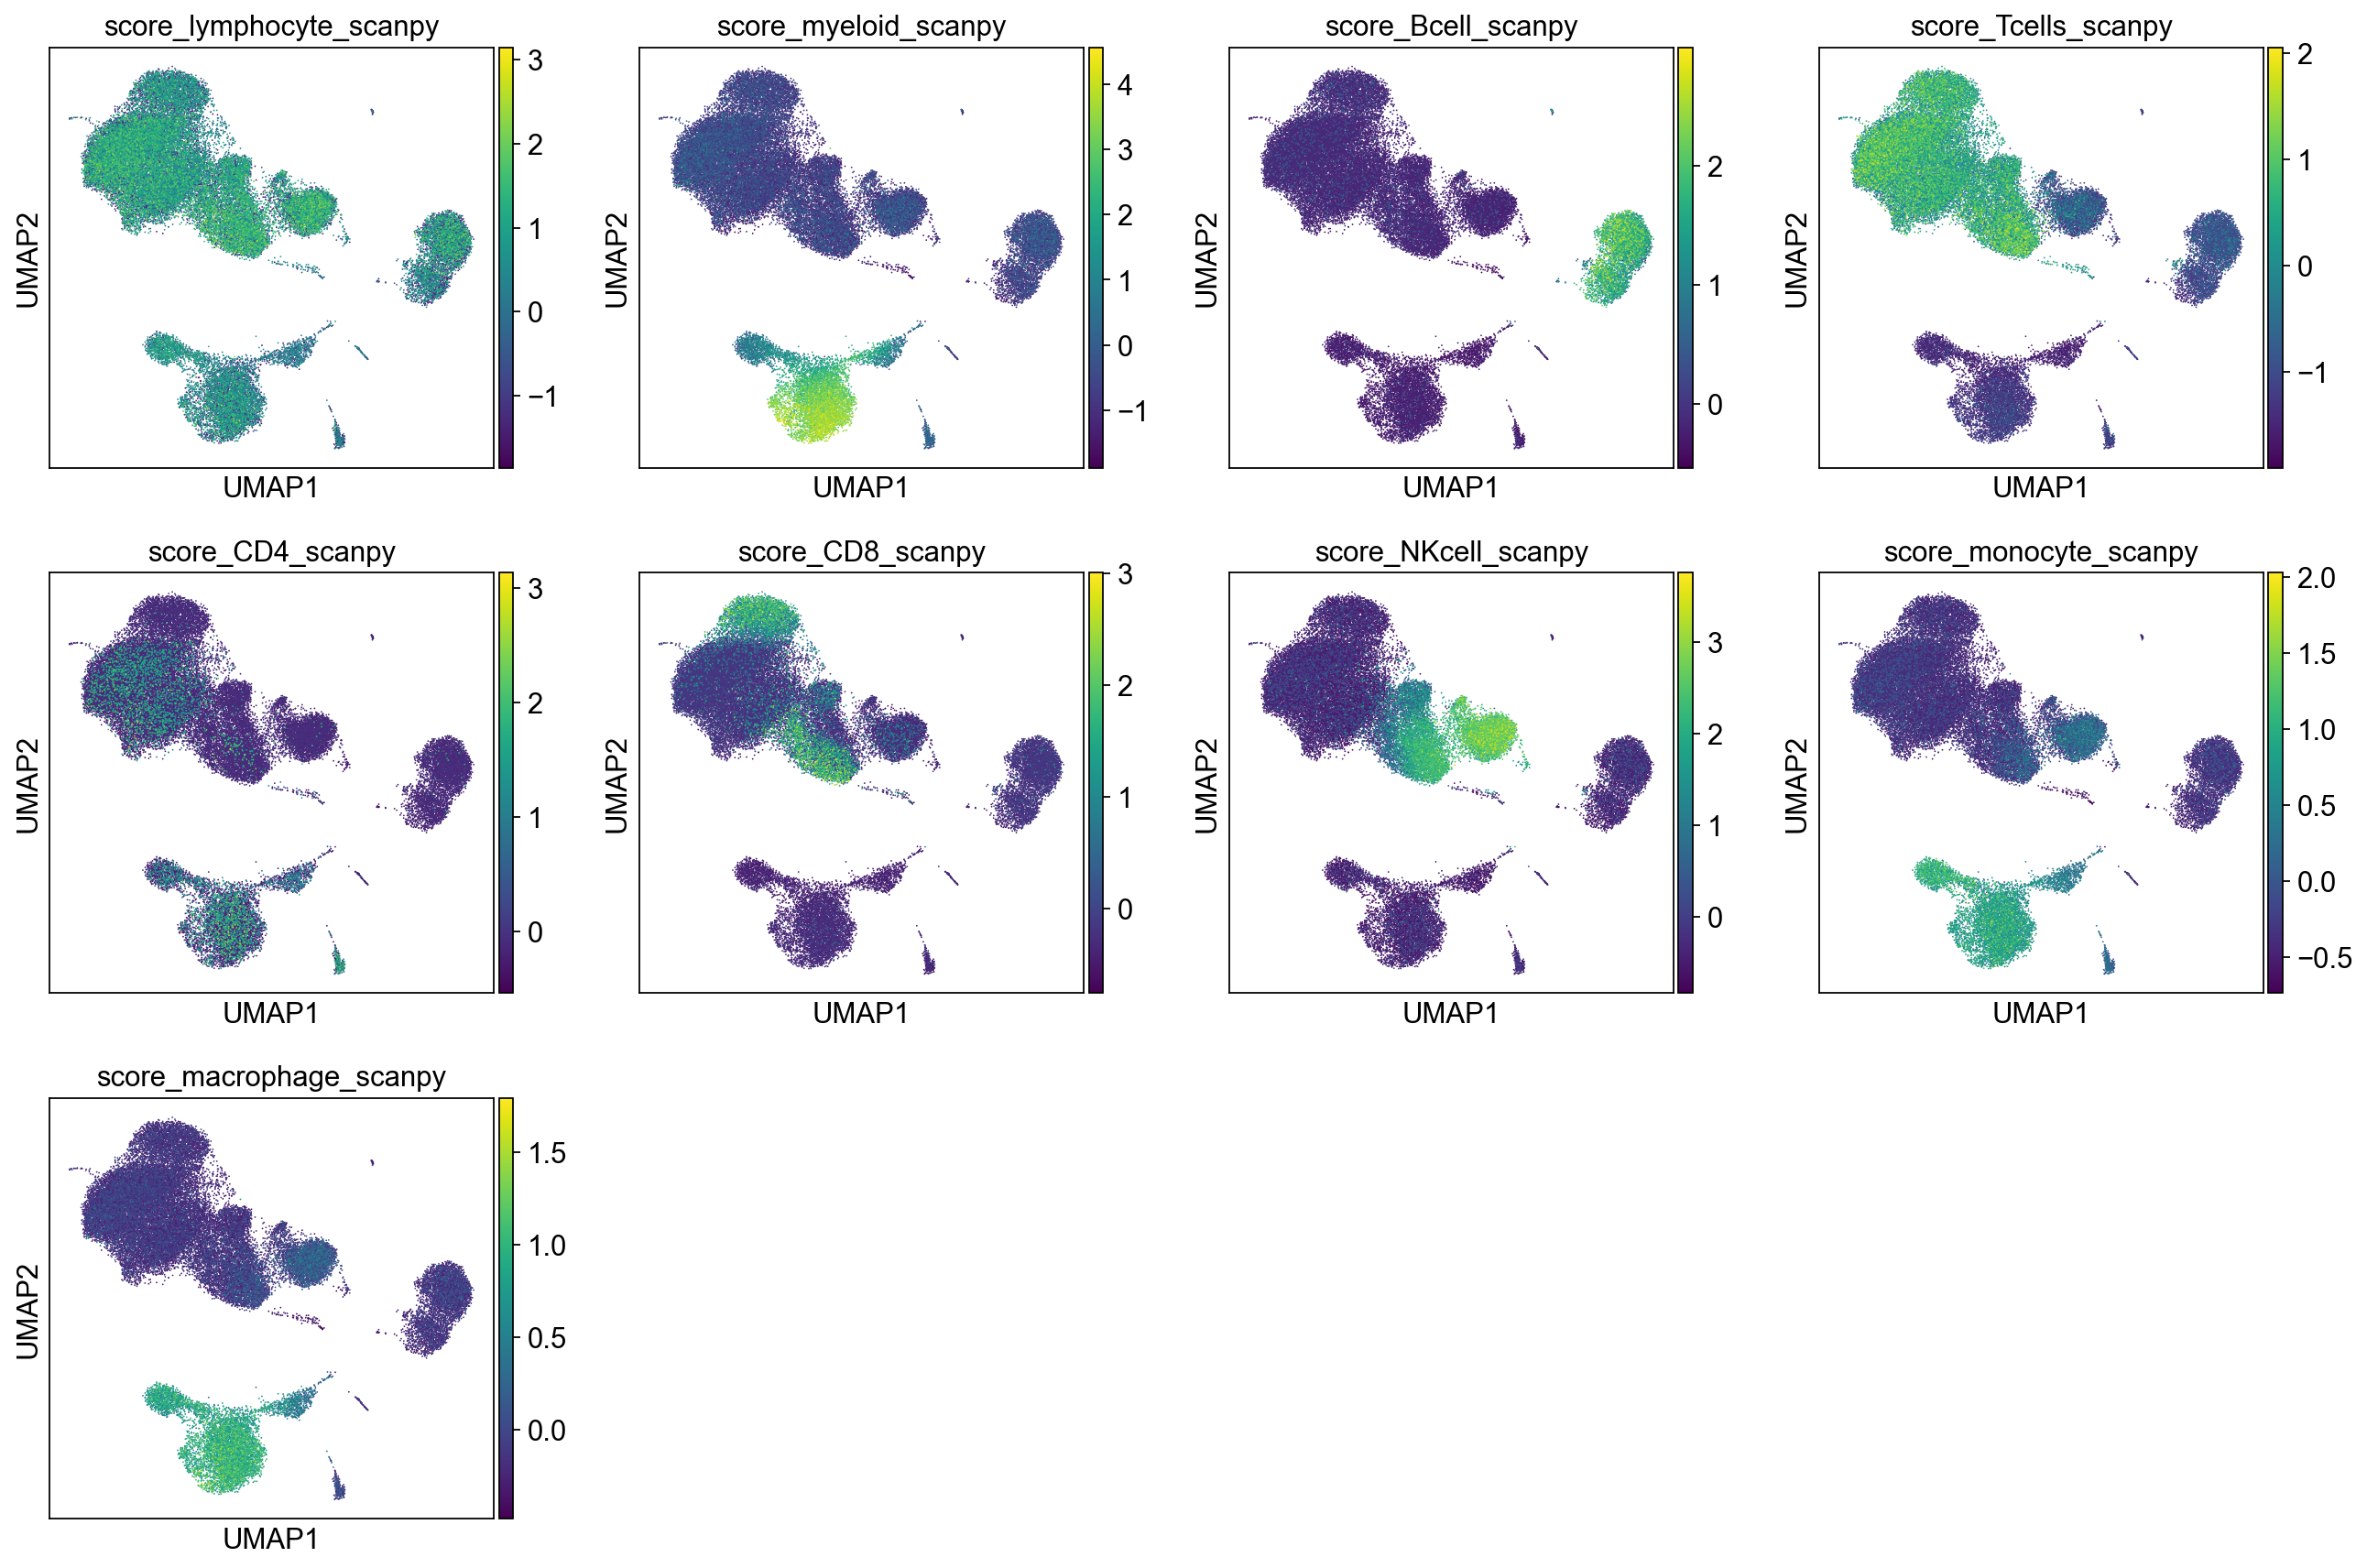

In [11]:
sc.pl.embedding(adata, basis = umap_basis, color= scores)

# Immune signatures for specific sub-populations

In [12]:
## PROVIDED WITH BESCA
gmt_file_anno= bescapath + '/besca/datasets/genesets/CellNames_scseqCMs6_sigs.gmt'
bc.tl.sig.combined_signature_score(adata, gmt_file_anno)

In [ ]:
scores = [x for x in adata.obs.columns if 'scanpy' in x]
sc.pl.embedding(adata, basis = umap_basis, color= scores, color_map = 'viridis')

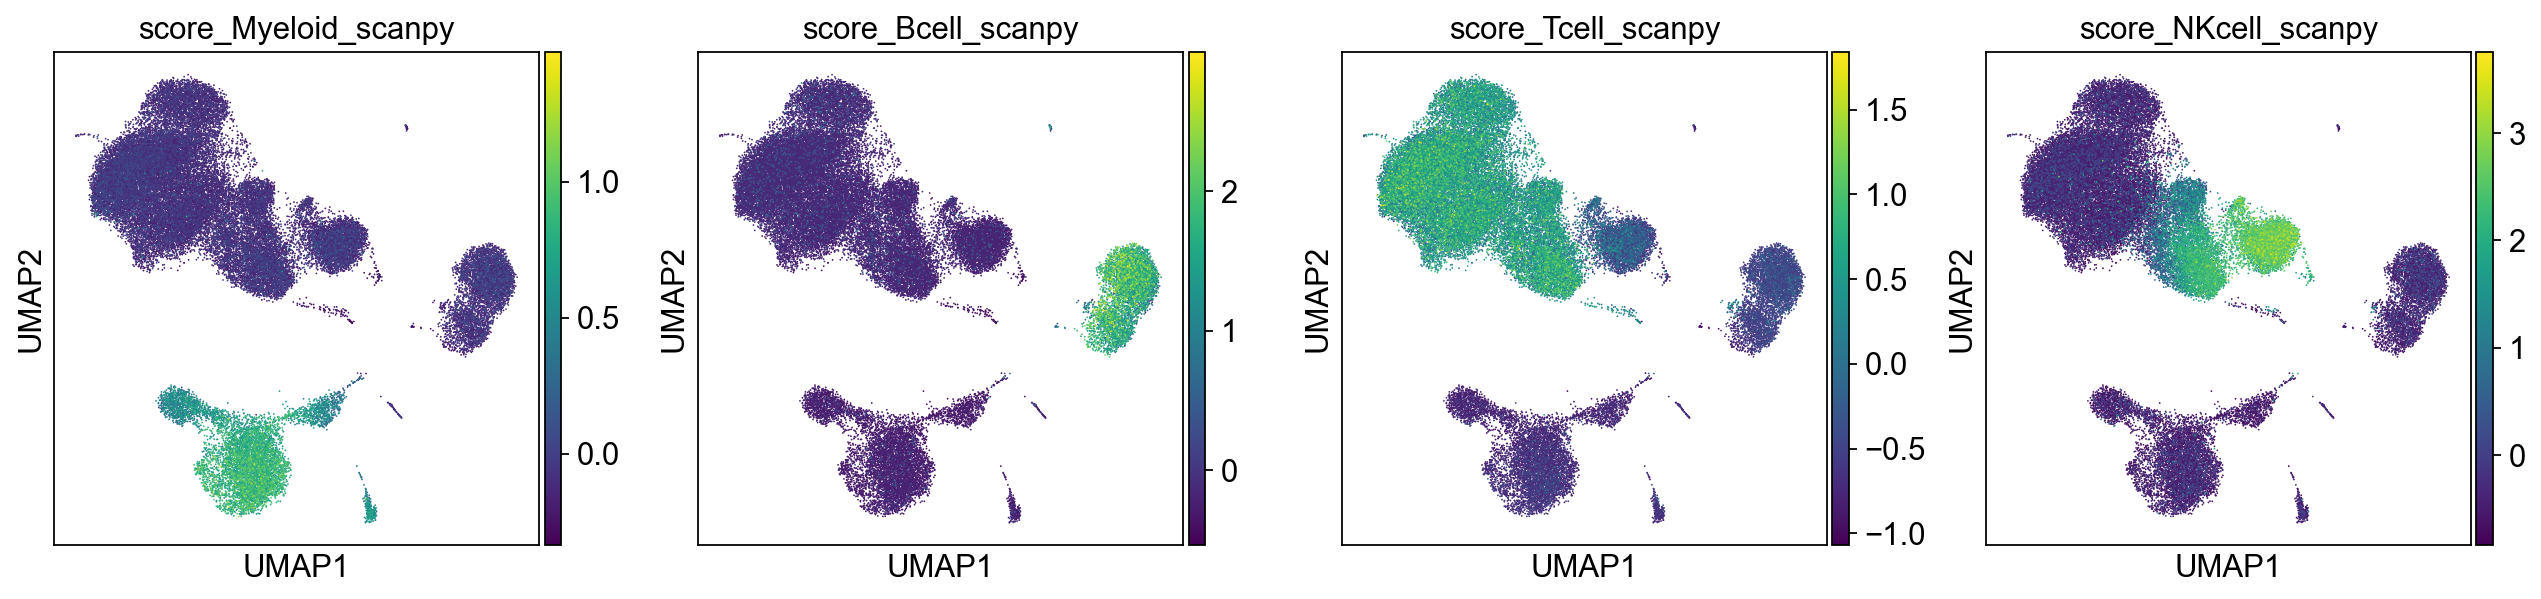

In [14]:
sc.pl.embedding(adata, basis = umap_basis, color= ['score_Myeloid_scanpy','score_Bcell_scanpy','score_Tcell_scanpy','score_NKcell_scanpy'], color_map = 'viridis')

# Automated annotation

A decision-tree-based annotation that reads signatures from a provided .gmt file and hierarchy as well as cutoffs and signature ordering from a configuration file and attributes each cell to a specific type according to signature enrichment. 

This is an aid to start the annotation process. The annotation can then be further refined by adding further signatures or adjusting the configuration files. It was tested mainly on PBMCs and oncology (tumor biopsies) related samples.


## Reclustering with higher resolution to more accurately annotate cells

If the standard clustering resuoltiion of 1.0 is used (especially for large datasets), it is very common that different cell sub-populations are put into the same cluster and can not be seperated. Reclustering the dataset with a higher resolution solves this issue.

leiden clustering performed with a resolution of 1.2


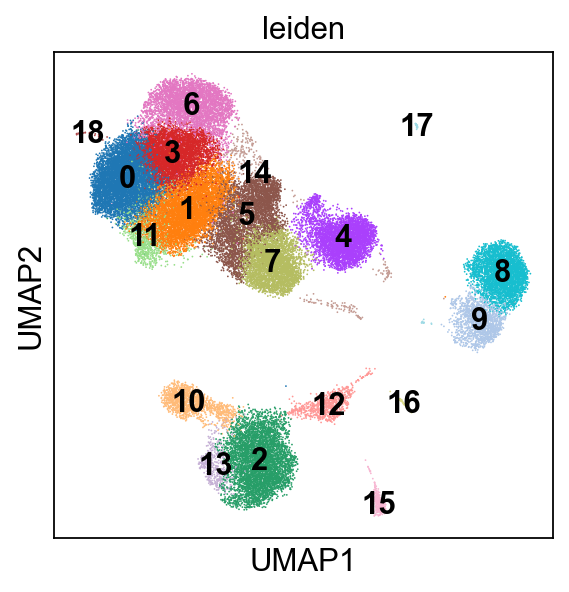

rank genes per cluster calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
.../data/CITESeq/analyzed/standard_workflow_besca2.0/labelings/leiden/WilxRank.gct written out
.../data/CITESeq/analyzed/standard_workflow_besca2.0/labelings/leiden/WilxRank.pvalues.gct written out
.../data/CITESeq/analyzed/standard_workflow_besca2.0/labelings/leiden/WilxRank.logFC.gct written out
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out


In [15]:
adata.obs[clusters+'_r1.0'] = adata.obs[clusters]
adata = bc.st.clustering(adata, results_folder, myres=1.2, method = clusters) 
bc.export.clustering(adata, outpath = os.path.join(results_folder, 'labelings', clusters+'_r1.2'), method = clusters)
bc.export.labeling_info(outpath=os.path.join(results_folder, 'labelings', clusters+'_r1.2'), description=clusters+' clustering with r=1.2', method='leiden')

## Loading markers and signature

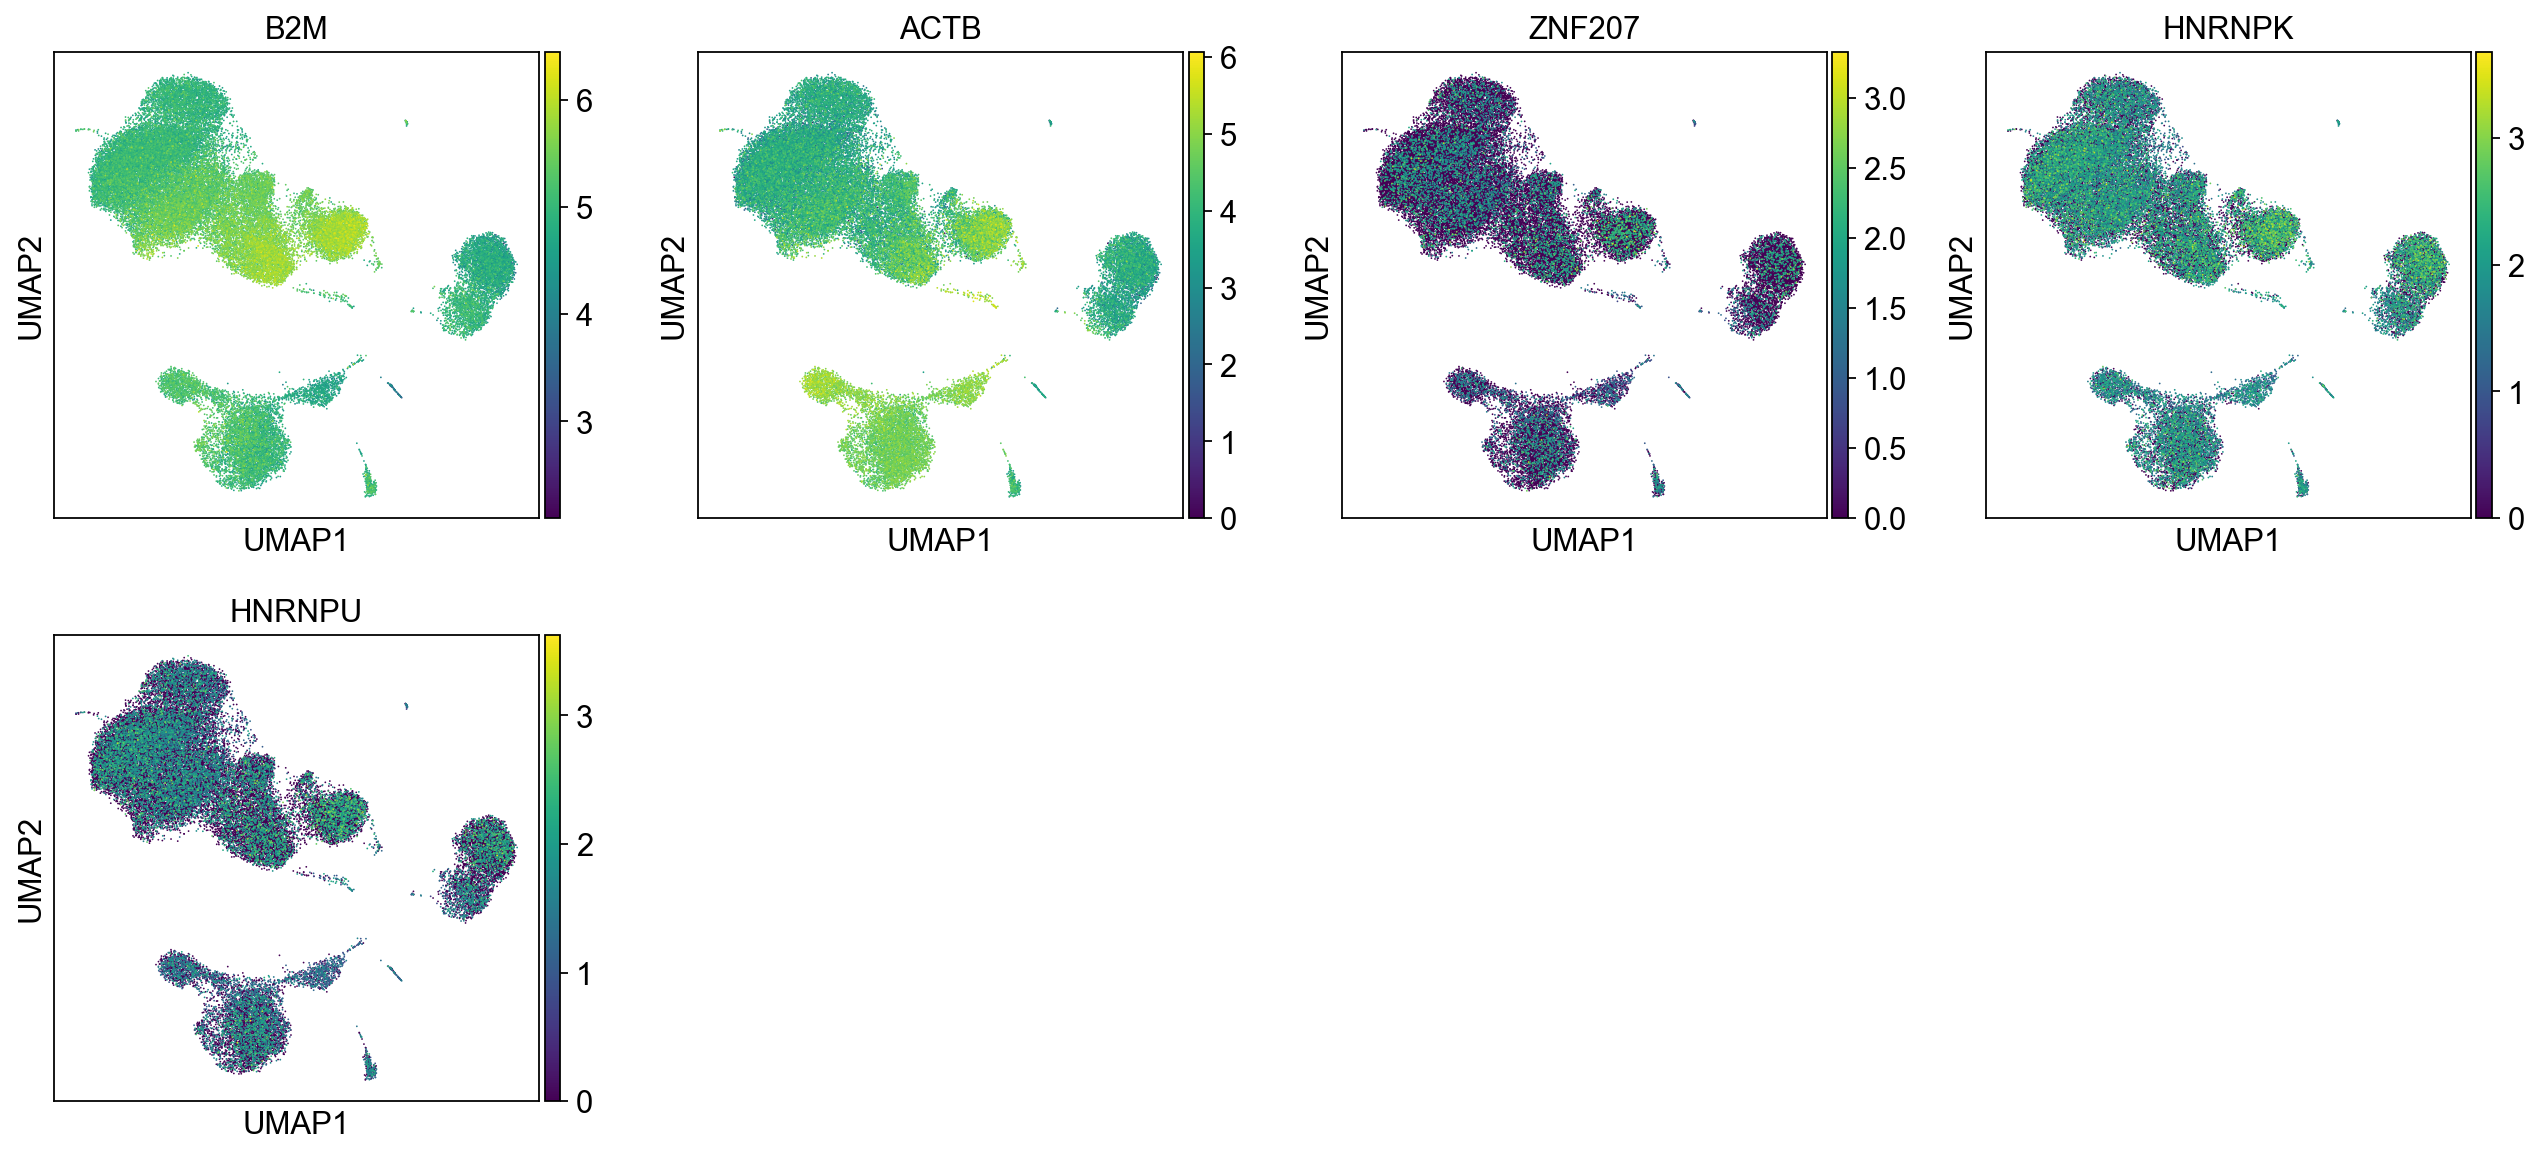

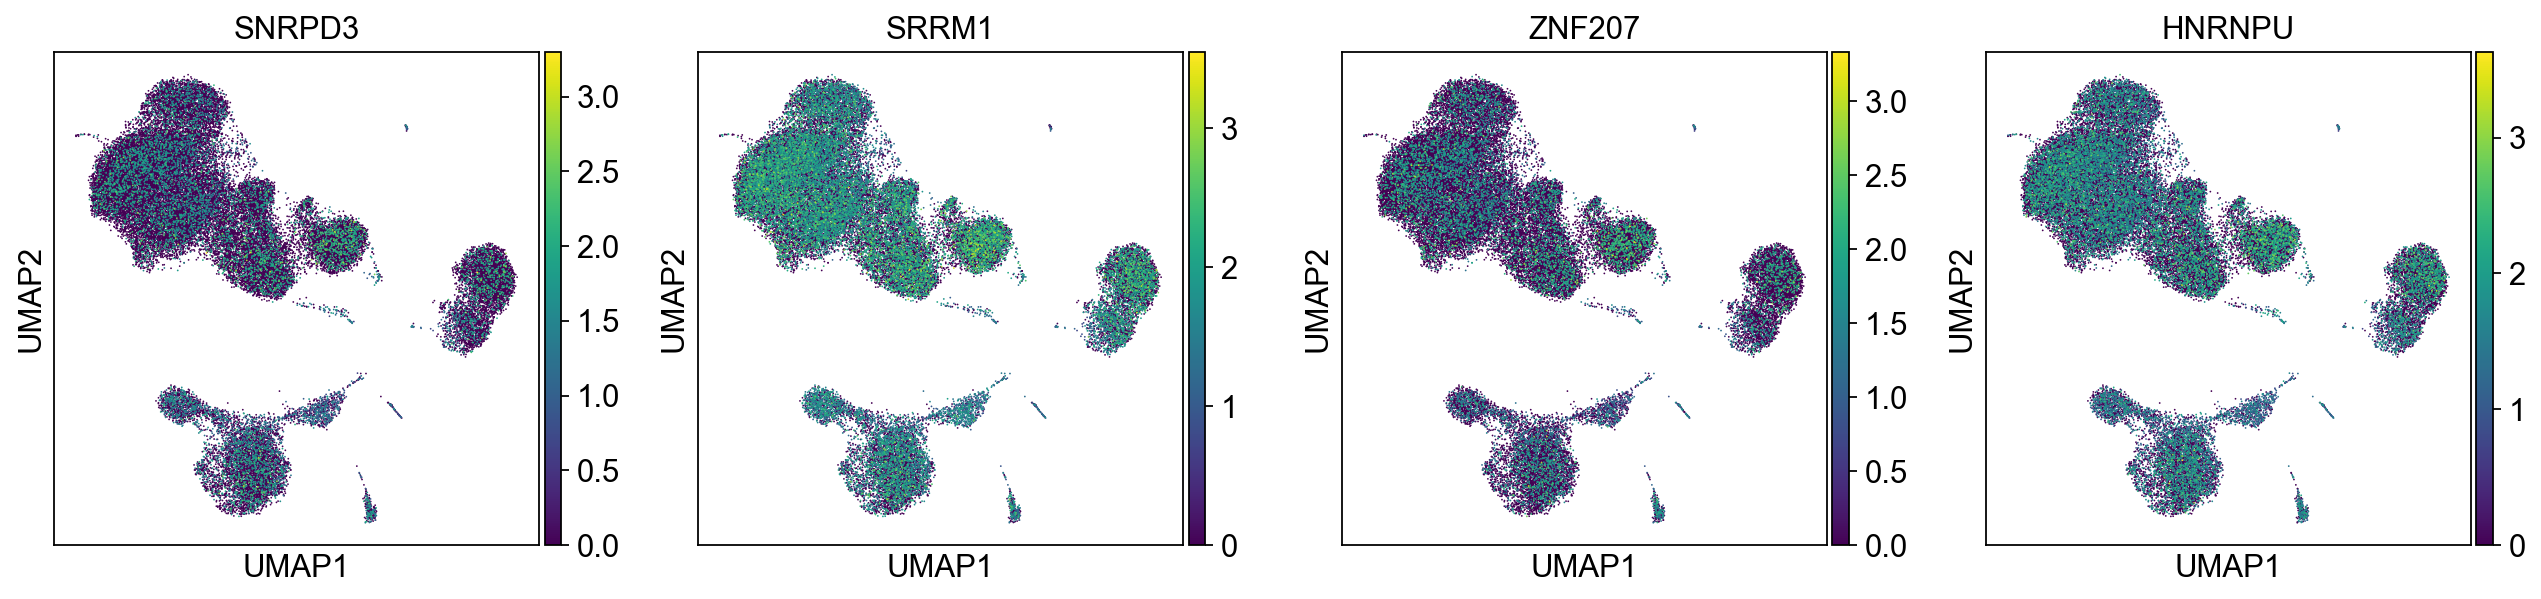

In [30]:
#old Ubi marker genes
sc.pl.umap(adata, color = ['B2M','ACTB', 'ZNF207', 'HNRNPK','HNRNPU'])

#old Ubi marker genes
sc.pl.umap(adata, color = ['SNRPD3', 'SRRM1', 'ZNF207', 'HNRNPU'])

In [17]:
mymarkers = bc.tl.sig.read_GMT_sign(gmt_file_anno, directed=False)
mymarkers = bc.tl.sig.filter_siggenes(adata, mymarkers) ### remove genes not present in dataset or empty signatures
mymarkers['Ubi'] = ['SNRPD3', 'SRRM1', 'ZNF207', 'HNRNPU'] ### used for cutoff adjustment to individual dataset, can be modified

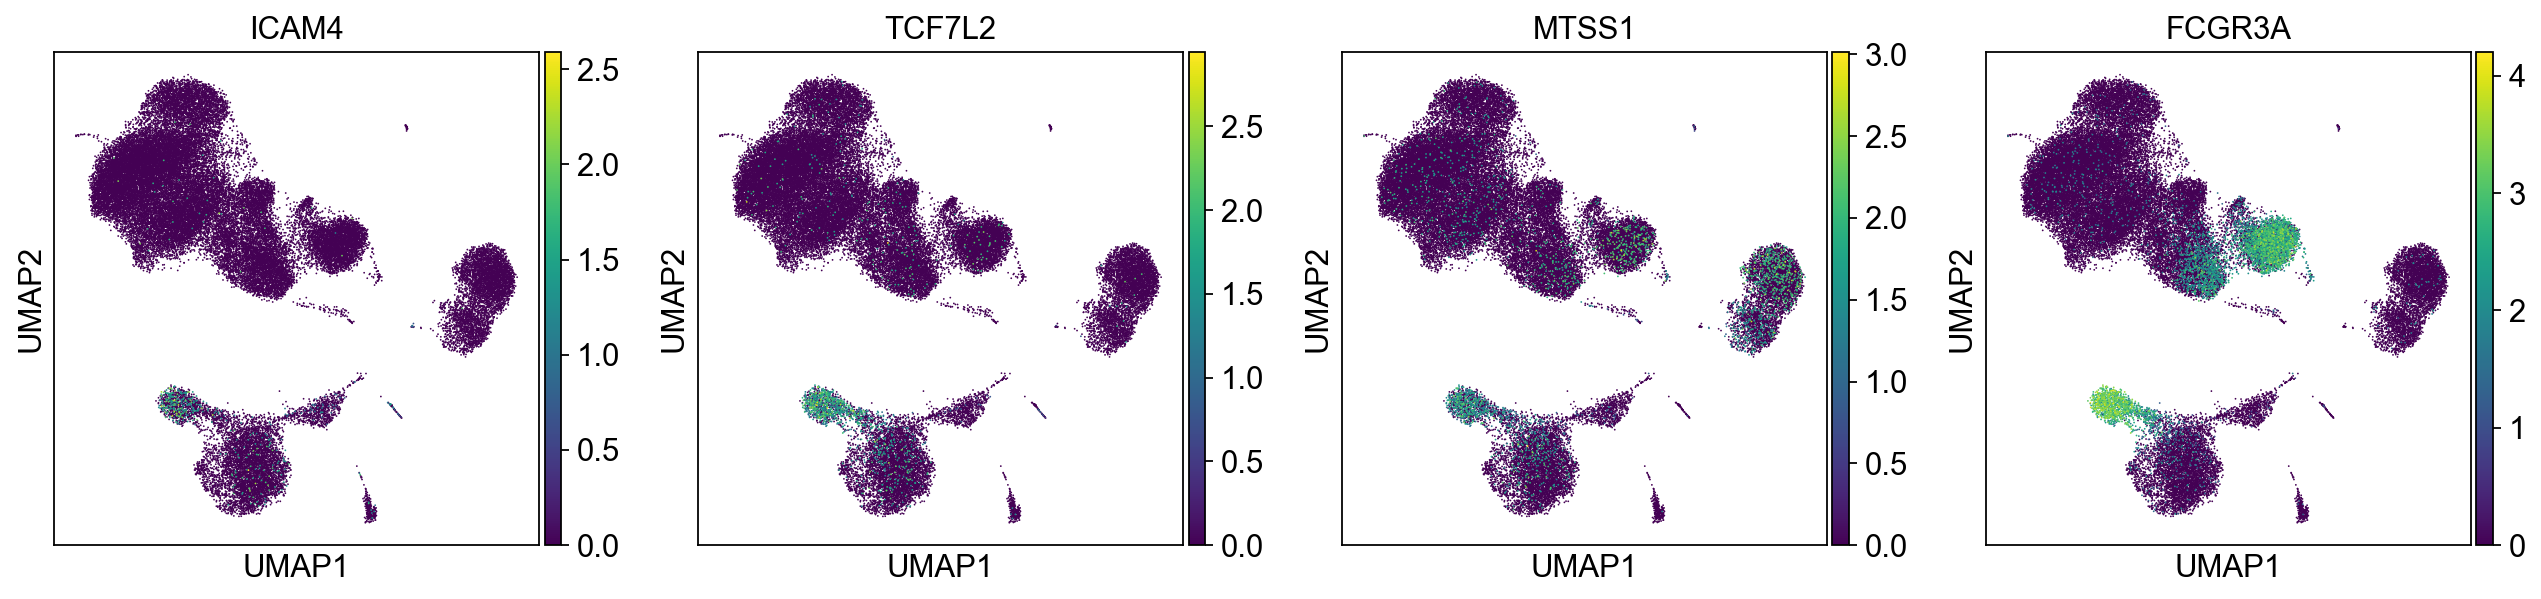

In [18]:
### Inspect gene expression for an example population
sc.pl.embedding(adata, basis = umap_basis, color= mymarkers['NClassMonocyte'])

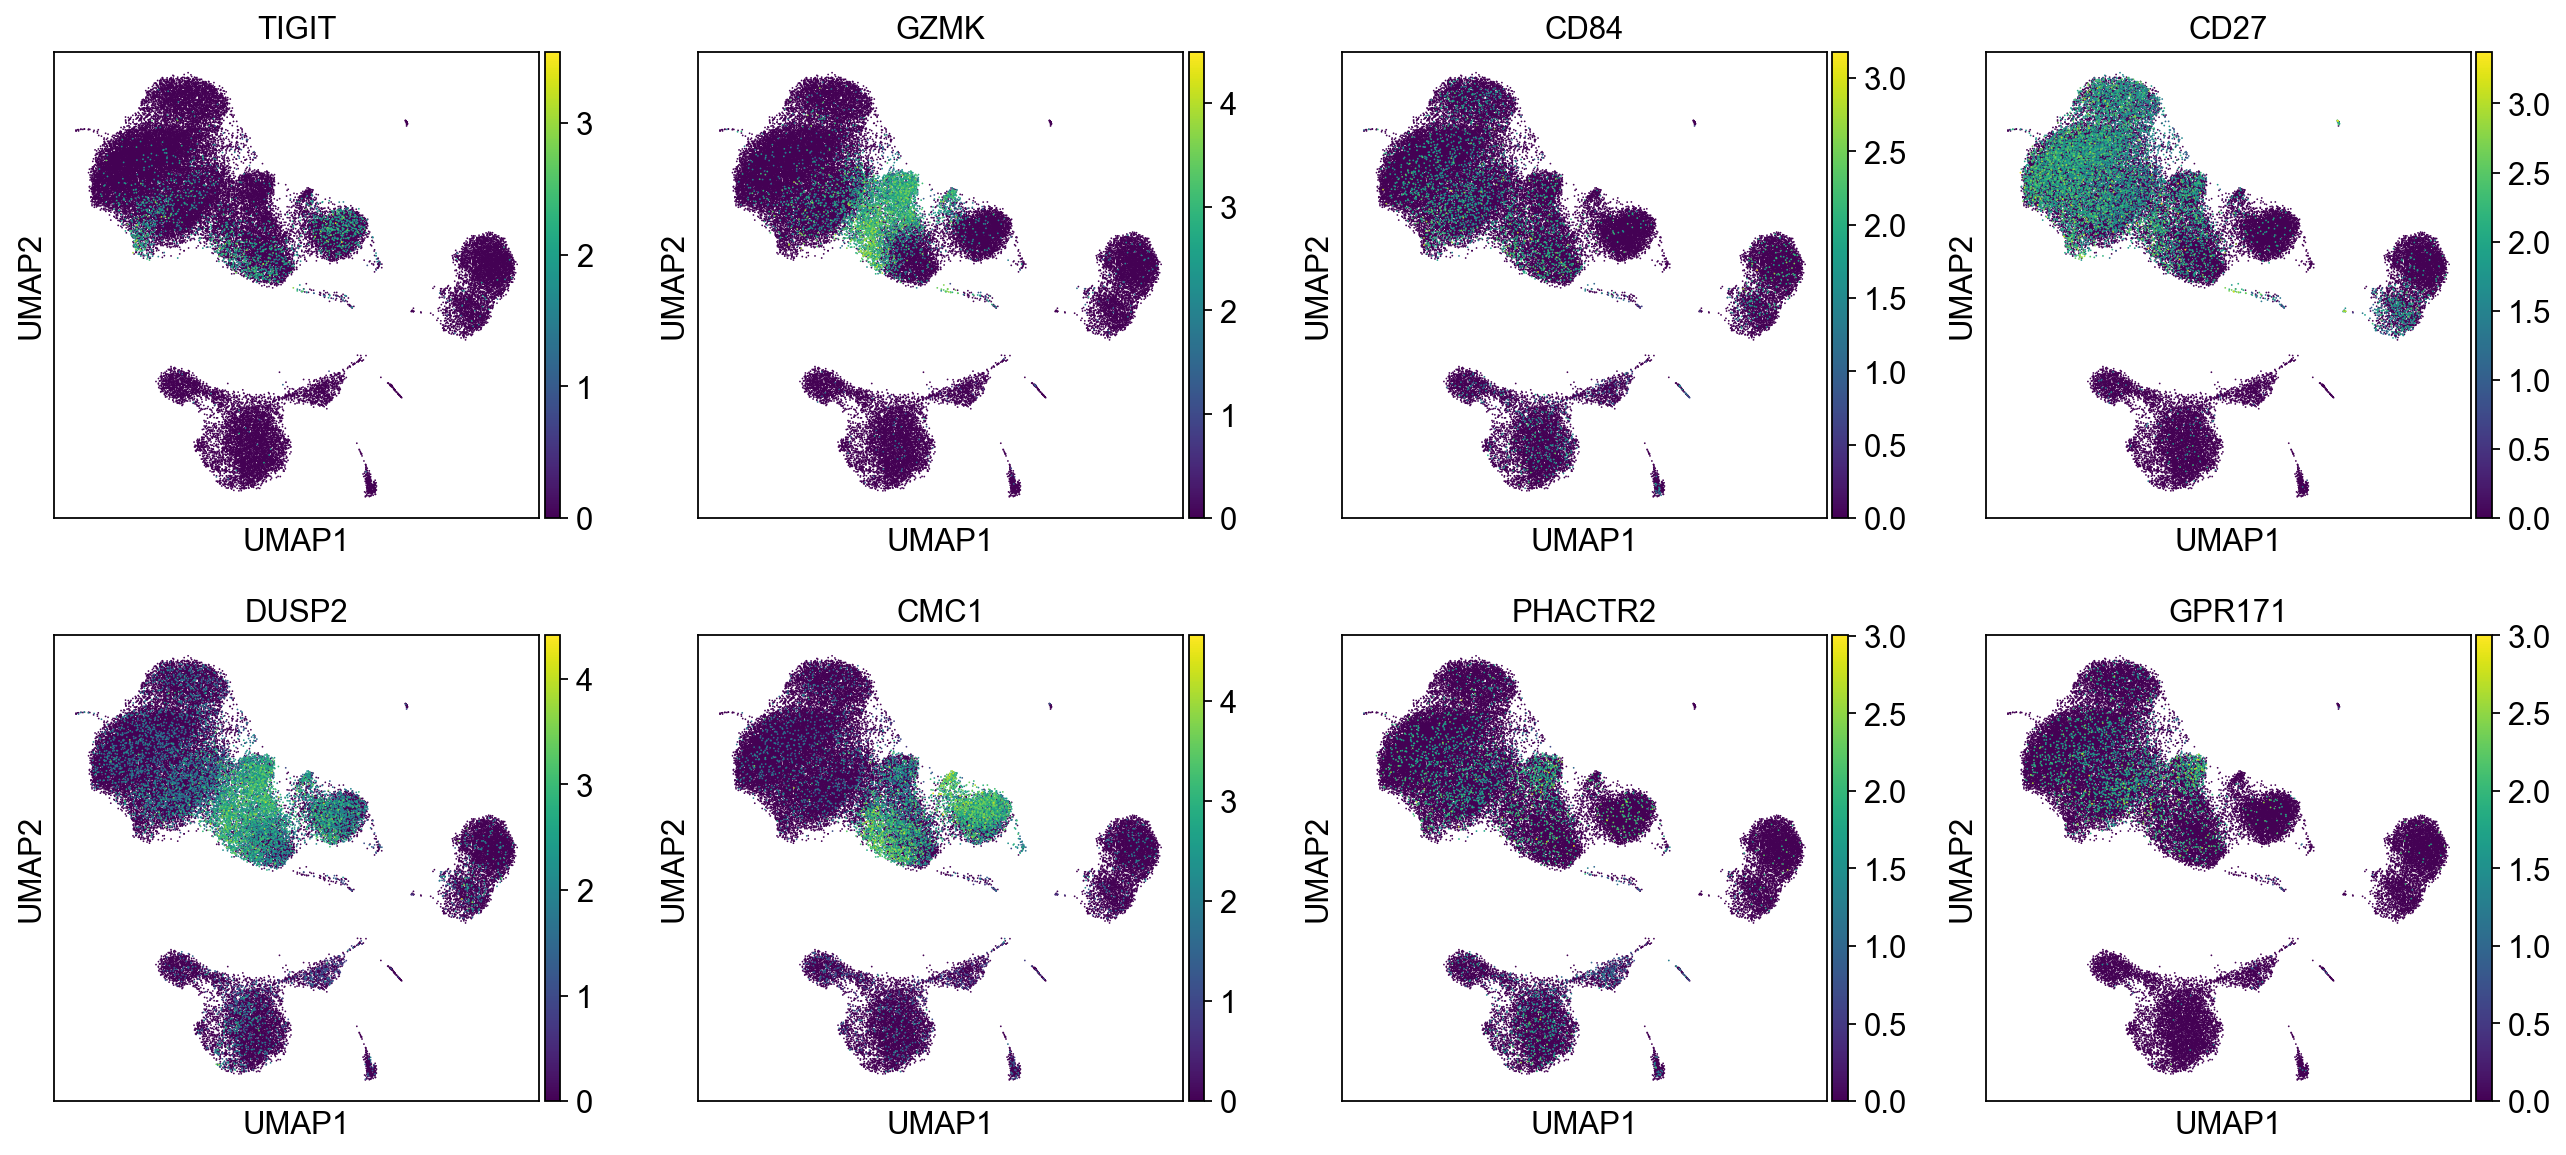

In [19]:
sc.pl.embedding(adata, basis = umap_basis, color = mymarkers['EMCD4Tcell'])

## Configuration of the annotation

We read the configuration file, containing hierarchy, cutoff and signature priority information. 
A new version of this file should be created and maintained with each annotation. 
The included example is optimised for the annotation of the 6.6k PBMC dataset. 

In [20]:
configfile=bescapath + '/besca/datasets/genesets/CellNames_scseqCMs6_config.tsv' ### replace this with your config
sigconfig,levsk = bc.tl.sig.read_annotconfig(configfile)

In [21]:
# The order of cells at different levels can be manually changed if needed
#levsk[0]=['ColorectalCancer', 'Epithelial','Fibroblast','Endothelial','Erythrocyte','HematoStem',
#          'Hepatocyte','MelMelanoma','Neural','Adipocyte','Hematopoietic','Schwann','Chondrocyte','Glial']

#### Get an overview of the cell type hierarchy included in the configuration file

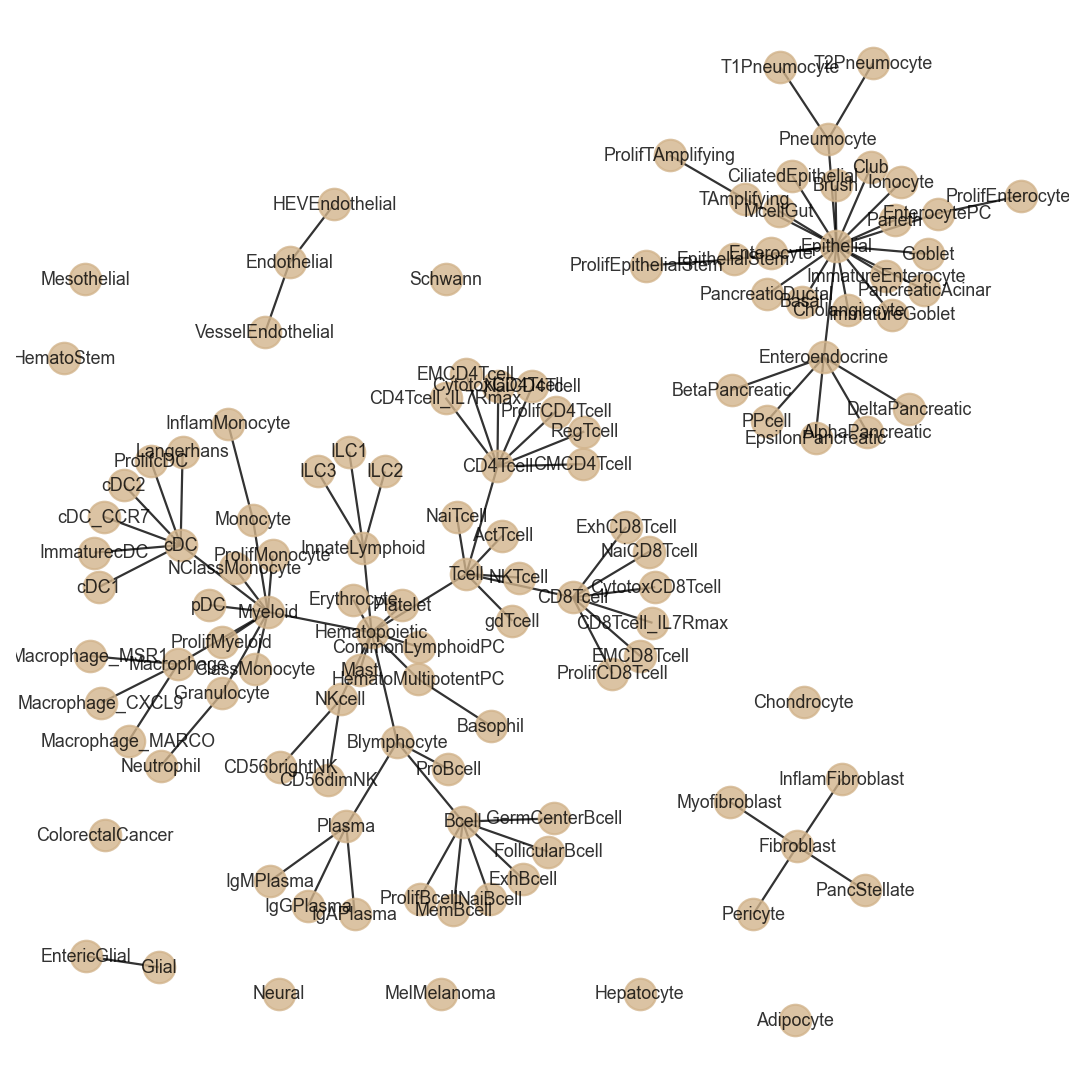

In [22]:
plt = bc.pl.nomenclature_network(configfile, font_size=8)
plt.savefig(figdir+"Nomenclatureplot.svg", format="svg")

Fract_pos was exported by BESCA in the standard worflow test, 
contains information of fraction positive cells per genes per cluster.

We use these values as a basis for a wilcoxon test per signature per cluster. 

In [23]:
f = pd.read_csv(results_folder + '/labelings/' + clusters + '/fract_pos.gct' ,sep="\t",skiprows=2)
df = bc.tl.sig.score_mw(f, mymarkers)
myc = np.median(df.loc['Ubi',:]*0.5) ### Set a cutoff based on Ubi and scale with values from config file
print('myc level: ', myc)

myc level:  35.597675766933236


#### For an overview of highest scoring signatures, one can generate a heatmap

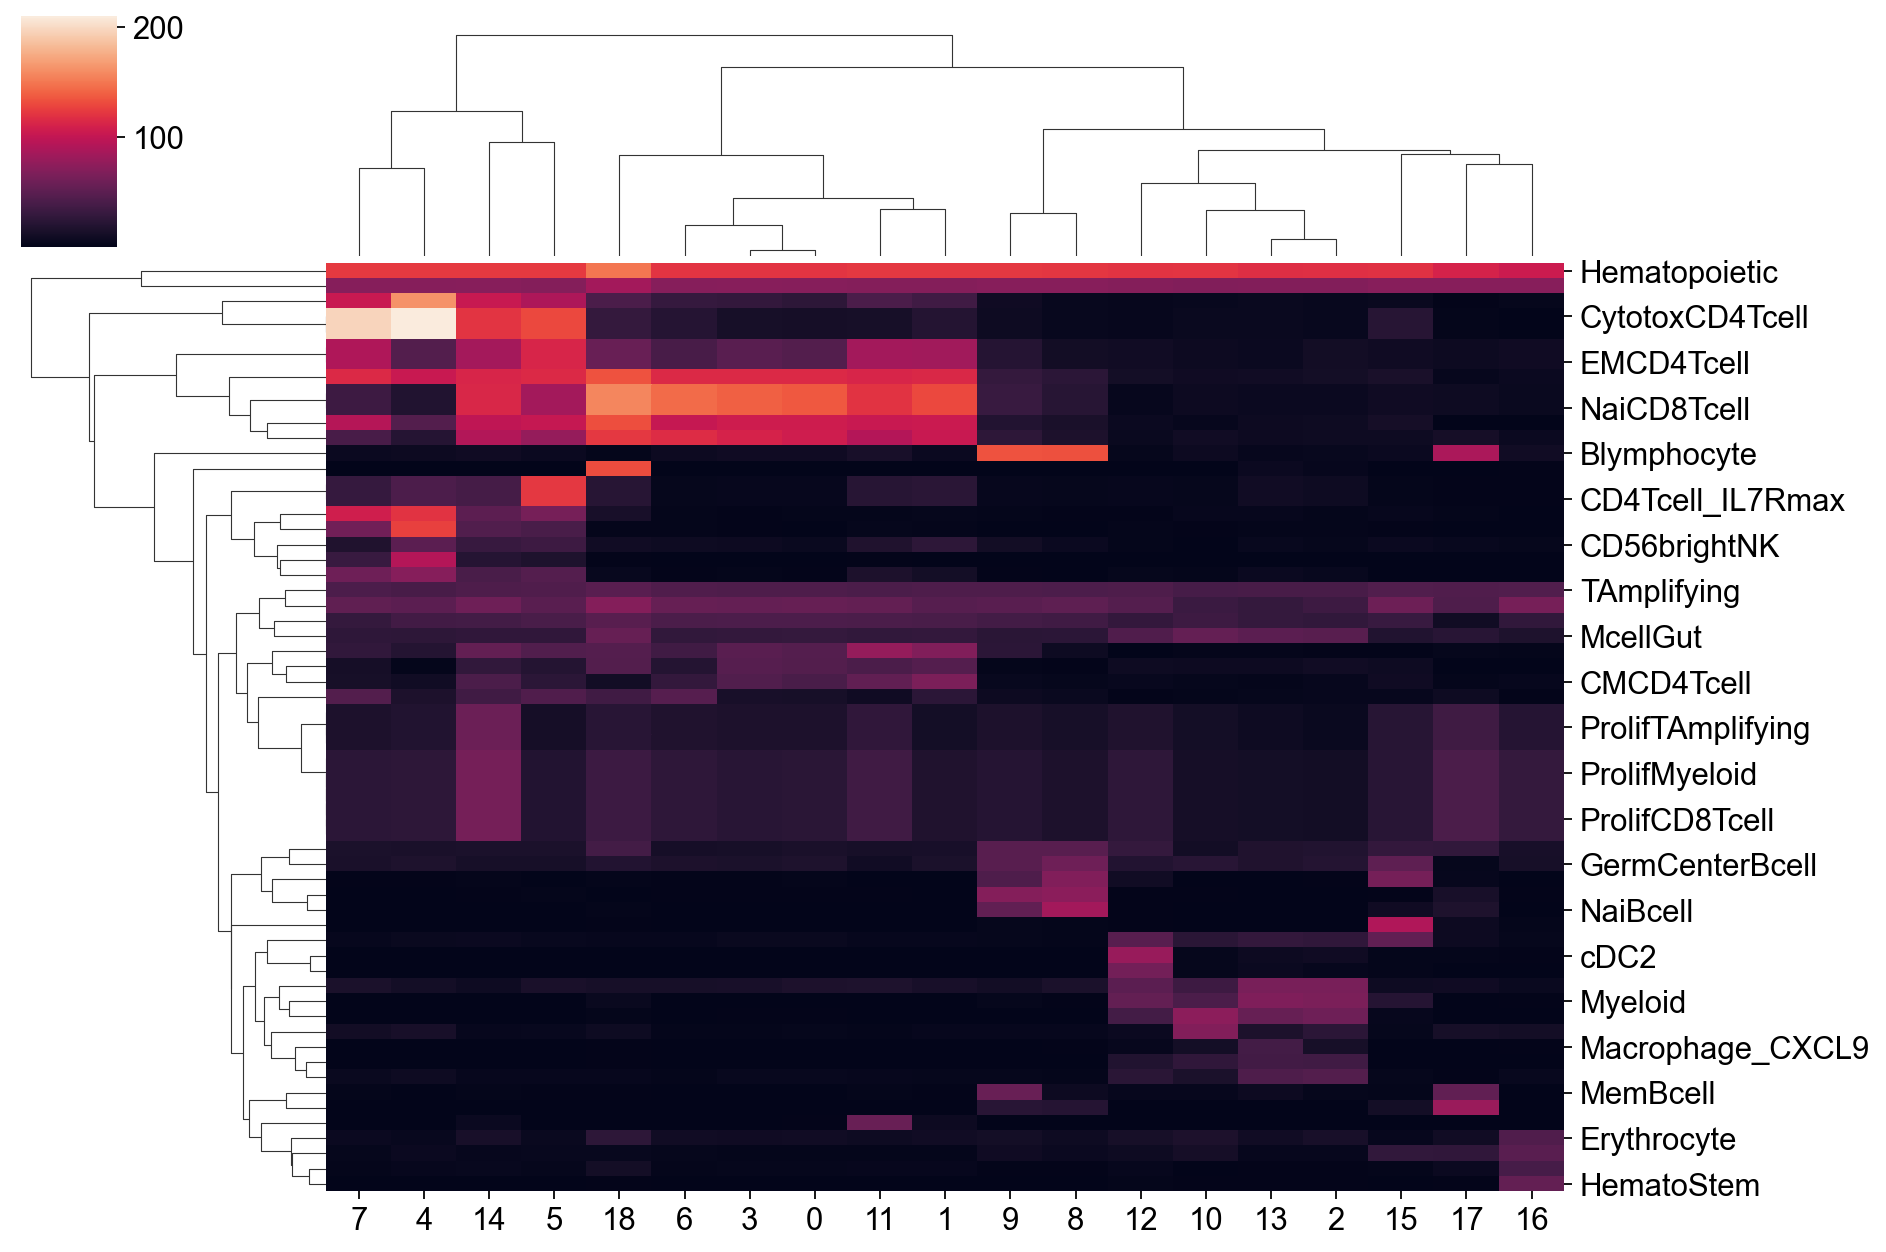

In [24]:
sns.clustermap(df.loc[df.max(axis=1)>myc*1,:].astype(float),figsize=(12, 8))
plt.savefig(figdir+"SignatureHeatmap_all.svg", format="svg")

For each signature, positive and negative clusters are determined. Only positive clusters are maintained. Cutoffs can be individualised based on the config file (scaling factor) and myc, which is determined based on ubiquitously expressed genes. 

In [25]:
df=df.drop('Ubi')

In [26]:
sigconfig.loc['CMCD4Tcell']

Parent    CD4Tcell
Cutoff         1.5
Order           32
Name: CMCD4Tcell, dtype: object

In [27]:
#Cluster attribution based on cutoff
sigscores={}
for mysig in list(df.index):
    sigscores[mysig]=bc.tl.sig.getset(df,mysig,sigconfig.loc[mysig,'Cutoff']*myc)
    #sigscores[mysig]=bc.tl.sig.getset(df,mysig,10)

#give an overview of the signature scores and see which cluster was attributed to which label
sigscores

{'Bcell': {'8', '9'},
 'Fibroblast': set(),
 'Endothelial': set(),
 'Epithelial': set(),
 'Granulocyte': set(),
 'MelMelanoma': set(),
 'MemBcell': {'9'},
 'Myeloid': {'10', '12', '13', '15', '18', '2'},
 'NKcell': {'4'},
 'NaiBcell': {'8'},
 'Neutrophil': set(),
 'Plasma': {'17'},
 'CD4Tcell': {'0', '1', '11', '14', '18', '2', '3', '5', '6', '7'},
 'CD8Tcell': {'5', '6', '7'},
 'Tcell': {'0', '1', '11', '14', '18', '3', '5', '6', '7'},
 'CD8Tcell_IL7Rmax': set(),
 'CD4Tcell_IL7Rmax': set(),
 'RegTcell': {'11'},
 'cDC1': set(),
 'cDC2': {'12'},
 'cDC': {'12'},
 'NClassMonocyte': {'10'},
 'pDC': {'15'},
 'Hematopoietic': {'0',
  '1',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9'},
 'Blymphocyte': {'17', '8', '9'},
 'CD56dimNK': {'4', '5', '7'},
 'CD56brightNK': set(),
 'NaiCD4Tcell': {'0', '18', '3', '6'},
 'NaiCD8Tcell': {'18', '6'},
 'ProlifCD8Tcell': set(),
 'ProlifCD4Tcell': set(),
 'ProlifBcell': set()

One can inspect the cluster attribution per cell type in the signature list and adjust cutoffs as required. 

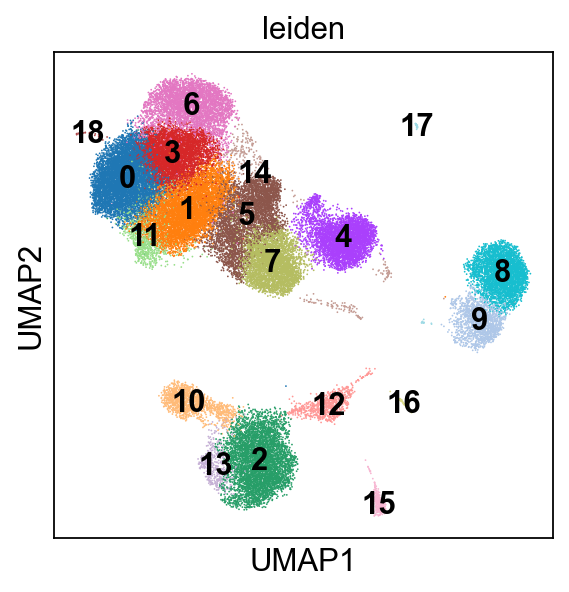

KeyError: 'celltype3'

In [28]:
sc.pl.umap(adata, color= [clusters], legend_loc='on data')
sc.pl.umap(adata, color= ['celltype3'])

Now each cluster gets annotated, according to the distinct levels specified in the config file. 
Note that in case a cluster is positive for multiple identities, only the first one is taken, 
in the order specified in the "Order" column in the config file. 

## Obtained cluster assignment

In [ ]:
### Cell types that are not expected in the dataset can be explicity excluded from the annotation 
toexclude=['AlphaPancreatic', 'BetaPancreatic', 'DeltaPancreatic']


We now obtain per each cluster cell type attribution at distinct levels. 

In [ ]:
cnames=bc.tl.sig.make_anno(df,sigscores,sigconfig,levsk, toexclude=toexclude)
cnames

Export the used annotation parameters, for future reference

In [ ]:
bc.tl.sig.export_annotconfig(sigconfig, levsk, results_folder, analysis_name)

## Using db label convention

Only short names were used in the signature naming convention in this case. 
One can easity tranform this to EFO terms if preferred, a conversion table comes with besca. 

This nomenclature is quite extended, and the function 
**obtain_dblabel** can perform the conversion.

In [ ]:
### transform these short forms to dblabel - EFO standard nomenclature
cnamesDBlabel = bc.tl.sig.obtain_dblabel(bescapath+'/besca/datasets/nomenclature/CellTypes_v1.tsv', cnames )
cnamesDBlabel

Finally, one can add the new labels to adata.obs as annotation. 

In [ ]:
adata.obs['celltype0']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype0',clusters)
adata.obs['celltype2']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype2',clusters)
adata.obs['celltype3']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype3',clusters)

In [ ]:
sc.pl.umap(adata,color=['leiden', 'celltype2'], wspace = 0.4) #,'celltype2'

In [ ]:
sc.pl.umap(adata,color=['celltype3']) #,'celltype3'

## Manual refinement

In some cases, the annotation does not produce the optimal result. Manual adjustments can be made, 
by replacing cell type names or by manually labeling clusters. Note that the second option is not 
stable across reruns if any adjustments are made to the clustering. 

In [ ]:
### Example 1: Classical monocytes contains both classical and non-classical monocytes, adjust to monocytes
#adata.obs['celltype2']=list(adata.obs['celltype2'].replace('classical monocyte', 'monocyte'))
#adata.obs['celltype3']=list(adata.obs['celltype3'].replace('classical monocyte', 'monocyte'))

In [ ]:
### Example 2: non-classical monocytes need to be added to a specific cluster
#adata.obs['celltype2']=adata.obs['celltype2'].cat.add_categories('non-classical monocyte')
#adata.obs['celltype3']=adata.obs['celltype3'].cat.add_categories('non-classical monocyte')
#adata.obs.loc[adata.obs[clusters].isin(['4']),'celltype2']='non-classical monocyte'
#adata.obs.loc[adata.obs[clusters].isin(['4']),'celltype3']='non-classical monocyte'

### Export labelling

Chosen labels can also be exported as a new folder in labelings/

In [ ]:

adata = bc.st.additional_labeling(adata, 'celltype3', 'celltype3', 'Major cell types', 'annot_author', results_folder)


### Follow-up analyses for marker generation

If one is interested in new markers, one can perform DE at the cell type annotation level of choice. 

In [ ]:
### Perform DE cells of each celltype3 vs. all other cells
DEgenes=bc.tl.dge.get_de(adata,'celltype3',demethod='wilcoxon',topnr=5000, logfc=1,padj=0.05)

If one is interested in additional markers correlated with the marker of interest, 
one can caculated the spearman correlation. 

In [ ]:
import scipy.stats as ss
import operator

allmarkers=adata.var_names

spearcorsAll = {}
for i in allmarkers:
    spearcorsAll[i]=ss.spearmanr(adata.raw[:, i].X.todense(),adata.raw[:,'MS4A1'].X.todense())[0]


spearcorsAll=sorted(spearcorsAll.items(),key=operator.itemgetter(1))
spearcorsAll_ids = [idx for idx, val in spearcorsAll]
goiNegAll=spearcorsAll_ids[0:30]
goiPosAll=spearcorsAll_ids[(len(spearcorsAll_ids)-30):len(spearcorsAll_ids)]

In [ ]:
sc.pl.dotplot(adata, var_names=goiPosAll,groupby='celltype3')

## FlowJo Gating

In [ ]:
#import flowjo labelling
barcodes = './celltypes/barcodes'
adata.obs['celltype_flowjo'] = 'not determined'

In [ ]:
barcodes_list = {}
for file in os.listdir(barcodes):
    if file in ['Tcells.csv', 'monocytes.csv']:
        continue
    name = file.replace('.csv', '')
    barcodes_list[name] = list(pd.read_csv(os.path.join(barcodes, file), header = None)[0])

In [ ]:
labels = pd.read_csv('./celltypes/Labeling_Citeseq_populations.csv', sep = ';', keep_default_na=False)
labels.index = labels.get("Unnamed: 0")

In [ ]:
adata.obs['celltype_flowjo_level1'] = 'not determined'

for name in barcodes_list.keys():
    if name in labels.index.tolist():
        label = labels.loc[name, "Level 1"]

        if label == "NA":
            continue

        _filter = [x in barcodes_list[name] for x in adata.obs.CELL]
        adata.obs.loc[_filter, 'celltype_flowjo_level1'] = label
    else:
        continue

adata.obs['celltype_flowjo_level2']   =   adata.obs['celltype_flowjo_level1']
    
for name in barcodes_list.keys():
    if name in labels.index.tolist():
        label = labels.loc[name, "Level 2"]

        if label == "NA":
            continue

        _filter = [x in barcodes_list[name] for x in adata.obs.CELL]
        adata.obs.loc[_filter, 'celltype_flowjo_level2'] = label
    else:
        continue

adata.obs['celltype_flowjo_level3']   =   adata.obs['celltype_flowjo_level2']
    
for name in barcodes_list.keys():
    if name in labels.index.tolist():
        label = labels.loc[name, "Level 3"]

        if label == "NA":
            continue

        _filter = [x in barcodes_list[name] for x in adata.obs.CELL]
        adata.obs.loc[_filter, 'celltype_flowjo_level3'] = label
    else:
        continue

In [ ]:
sc.pl.umap(adata, color = ['celltype3'], ncols = 1, save = ".celltype3.svg")

In [ ]:
sc.pl.umap(adata, color = ['celltype_flowjo_level3'], ncols = 1, save = ".celltypeflowjo_level3.svg")

In [ ]:
sc.pl.umap(adata, color = ['celltype_flowjo_level2'], ncols = 1, save = ".celltypeflowjo_level2.svg")

In [ ]:
sc.pl.umap(adata, color = ['celltype2'], ncols = 1, save = ".celltype2.svg")

### Convert to html

In [ ]:
nb_name = os.path.join(os.getcwd(), 'celltype_annotation')

In [ ]:
! jupyter nbconvert --to html {nb_name}